In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio

In [2]:
images_0 = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/0/*.png")):
    images_0.append((imageio.imread(image_path), 0))
images_1 = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/1/*.png")):
    images_1.append((imageio.imread(image_path), 1))

I will histogram the rgb values to see if there is a significant spike to determine if I can switch to grey scale.

In [3]:
def get_histogram(images, scale):
    if scale == "rgb":
        colors = "rgb"
        pixel_vals = {"r":[], "g":[], "b":[]}
    else:
        colors = "k"
        pixel_vals = {"k":[]}
    for i in range(len(images)):
        for j in range(len(images[i][0])):
            for k in range(len(images[i][0][j])):
                for idx, color in enumerate(colors):
                    if color != "k":
                        pixel_vals[color].append(images[i][0][j][k][idx])
                    else:
                        pixel_vals[color].append(images[i][0][j][k])
    return pixel_vals

In [4]:
def plot_histograms(images, scale="rgb"):
    if scale == "rgb":
        colors = "rgb"
        num_plots = 3
    else:
        colors = "k"
        num_plots = 1
    pixel_vals = get_histogram(images, scale)
    fig, ax = plt.subplots(num_plots, figsize=(18,18))
    for i, color in enumerate(colors):
        if color != "k":
            ax[i].hist(pixel_vals[color], bins="auto")
        else:
            ax.hist(pixel_vals[color], bins="auto")

In [5]:
images_rgb = images_0 + images_1

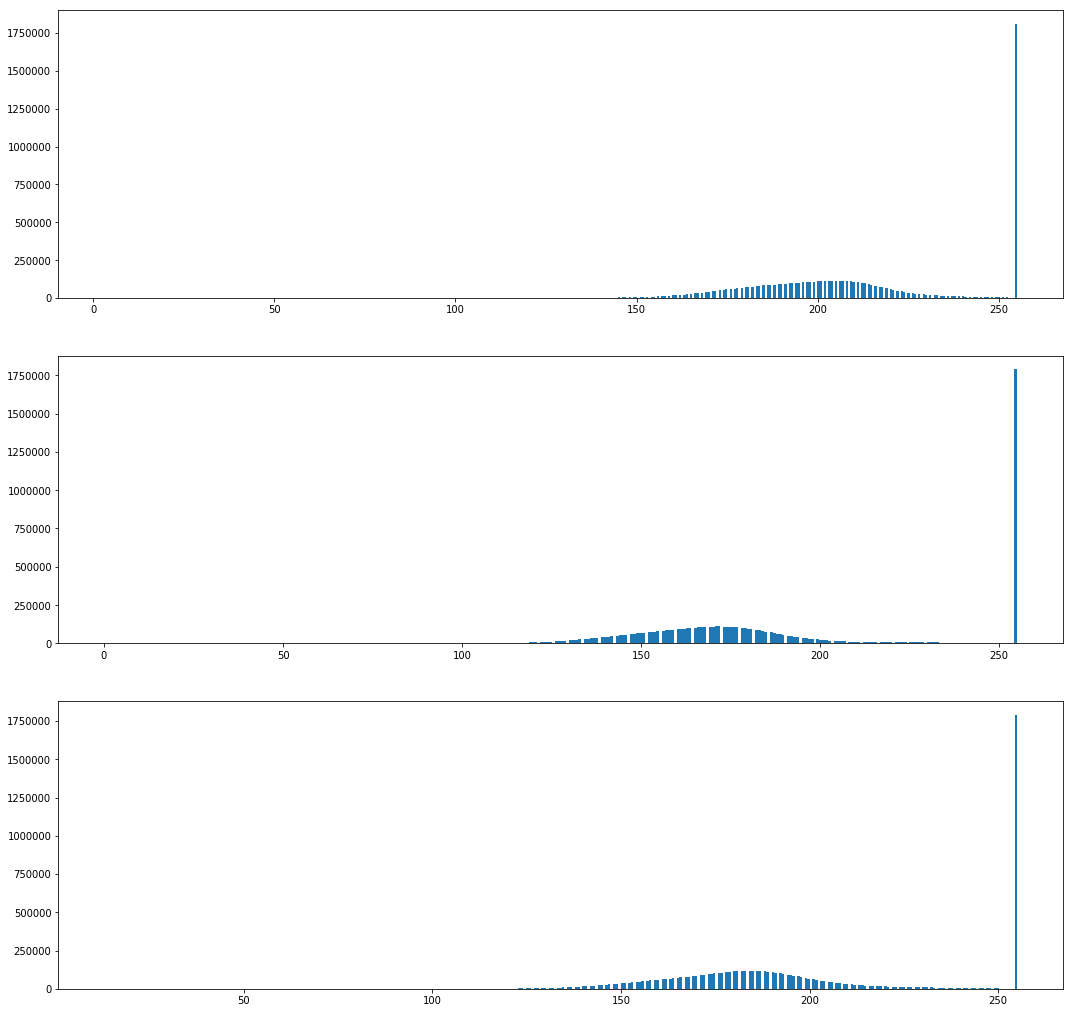

In [6]:
plot_histograms(images_rgb)

From the histograms we can see that the image is predominantly white space with a clear distribution around one color (namely purple here). We can load in the data in grey scale intead to reduce the dimensions of each pixel from 3 to 1.

In [3]:
from PIL import Image, ImageOps

In [7]:
images_0 = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/0/*.png"), ):
    img = np.array(Image.open(image_path).convert("L"))
    images_0.append((img, 0))
images_1 = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/1/*.png")):
    img = np.array(Image.open(image_path).convert("L"))
    images_1.append((img, 1))

In [8]:
images_grey = images_0 + images_1

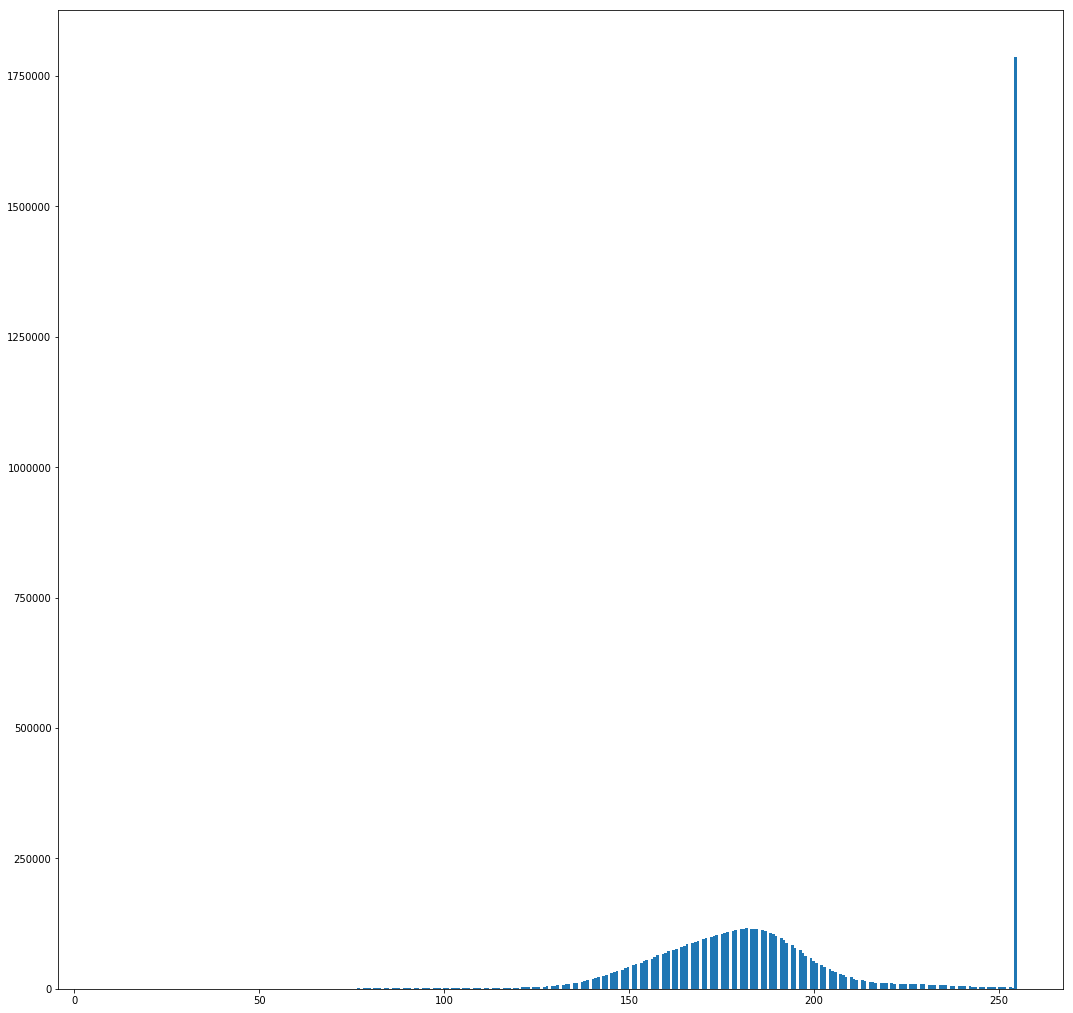

In [10]:
plot_histograms(images_grey, "grey")

Greyscale should work it seems.

In [11]:
for i in range(10):
    print(images_grey[i][0].shape)

(55, 56)
(58, 55)
(53, 53)
(56, 54)
(52, 57)
(33, 32)
(63, 57)
(44, 55)
(35, 60)
(44, 53)


In [4]:
images_0 = []
images_0_rgb = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/0/*.png")):
    img = np.array(Image.open(image_path).convert("L").resize((64,64)))
    images_0.append((img, 0))
    img_rgb = np.array(Image.open(image_path).resize((64,64)))
    images_0_rgb.append((img_rgb, 0))
images_1 = []
images_1_rgb = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/1/*.png")):
    img = np.array(Image.open(image_path).convert("L").resize((64,64)))
    images_1.append((img, 1))
    img_rgb = np.array(Image.open(image_path).resize((64,64)))
    images_1_rgb.append((img_rgb, 1))

In [5]:
images_grey_resized  = images_0 + images_1
images_rgb_resized  = images_0_rgb + images_1_rgb

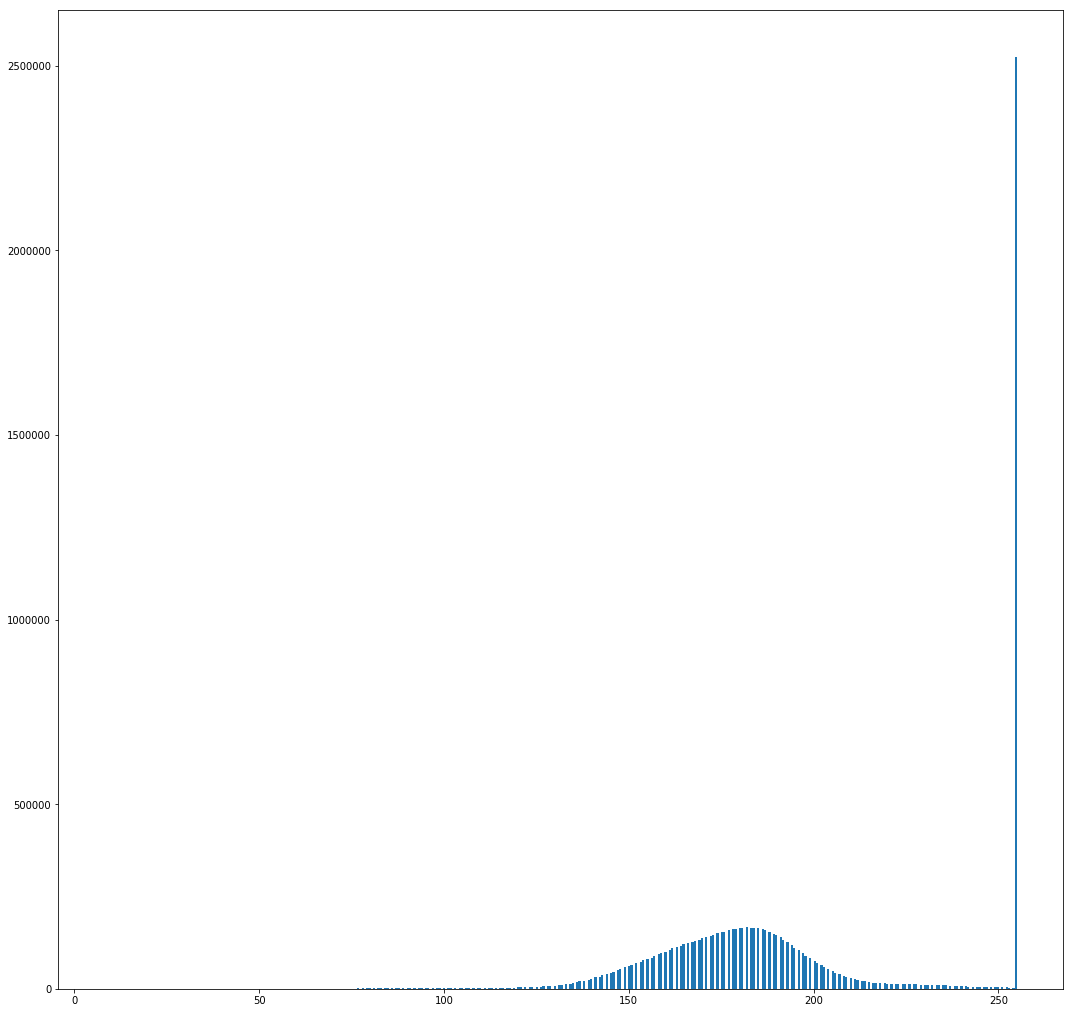

In [14]:
plot_histograms(images_grey_resized, "grey")

In [15]:
for i in range(10):
    print(images_grey_resized[i][0].shape)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


In [6]:
from sklearn.decomposition import PCA

In [76]:
np.shape(images_rgb_resized[0][0])

(64, 64, 3)

In [78]:
len(images_rgb_resized)

2565

In [7]:
imgs = []
classes = []
zeroes = []
ones = []
for index, img in enumerate(images_rgb_resized):
    imgs.append(img[0].flatten())
    classes.append(img[1])
    if img[1] == 0:
        zeroes.append(index)
    else:
        ones.append(index)
imgs = np.array(imgs)
classes = np.array(classes)

In [34]:
imgs.shape

(2565, 12288)

In [8]:
imgs_minmax_scaled = imgs

In [9]:
pca = PCA()
pca.fit(imgs_minmax_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
variance_break = 0.1
for i, evr in enumerate(pca.explained_variance_ratio_):
    if evr * 100 < variance_break:
        var_index_break = i
        print(i)
        break

85


In [11]:
pca_ = PCA(n_components=var_index_break)
pca_.fit(imgs_minmax_scaled)
imgs_pca = pca_.transform(imgs_minmax_scaled)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [13]:
def train_val_test_split(train, val, test, zeroes, ones, seed=42):
    np.random.seed(seed)
    shuf_zeroes = np.random.shuffle(zeroes)
    shuf_ones = np.random.shuffle(ones)
    
    train_zeroes_stop = int(train*len(zeroes))
    val_zeroes_stop = int(val*len(zeroes)) + train_zeroes_stop
    
    train_ones_stop = int(train*len(ones))
    val_ones_stop = int(val*len(ones)) + train_ones_stop
    
    train_zeroes = zeroes[:train_zeroes_stop]
    val_zeroes = zeroes[train_zeroes_stop:val_zeroes_stop]
    test_zeroes = zeroes[val_zeroes_stop:]
    
    train_ones = ones[:train_ones_stop]
    val_ones = ones[train_ones_stop:val_ones_stop]
    test_ones = ones[val_ones_stop:]
    
    train_indices = train_zeroes + train_ones
    val_indices = val_zeroes + val_ones
    test_indices = test_zeroes + test_ones
    
    return train_indices, val_indices, test_indices

In [66]:
train_idx, val_idx, test_idx = train_val_test_split(0.7, 0.1, 0.2, zeroes, ones)

In [67]:
train_data = imgs_pca[train_idx]
val_data = imgs_pca[val_idx]
test_data = imgs_pca[test_idx]

train_class = classes[train_idx]
val_class = classes[val_idx]
test_class = classes[test_idx]

In [68]:
print(sum(train_class))
print(sum(val_class))
print(sum(test_class))

723
103
208


In [71]:
clf = SVC(kernel="rbf", gamma='scale', class_weight="balanced")
clf.fit(train_data, train_class)

#rf = RandomForestClassifier(max_depth=10, random_state=0)
#rf.fit(train_data, train_class)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [72]:
print(clf.score(train_data, train_class))
print(clf.score(val_data, val_class))
print(clf.score(test_data, test_class))

#print(rf.score(test_data, test_class))

0.987736900780379
0.9296875
0.9475728155339805


In [19]:
from sklearn.ensemble import AdaBoostClassifier

In [23]:
ada = AdaBoostClassifier(base_estimator=SVC(probability=True, kernel="rbf", gamma="scale", class_weight="balanced"), n_estimators=25, random_state=0)
ada.fit(train_data, train_class)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          learning_rate=1.0, n_estimators=25, random_state=0)

In [24]:
print(ada.score(train_data, train_class))
print(ada.score(test_data, test_class))

0.8057722308892356
0.7962674961119751


In [28]:
def conf_mat(actual, predict):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(actual)):
        if actual[i] == predict[i] and actual[i]:
            tp += 1
        elif actual[i] == predict[i]:
            tn += 1
        elif predict[i]:
            fp += 1
        else:
            fn += 1
    return np.array([[tp, fn], [fp, tn]], dtype=int)

In [75]:
print(conf_mat(test_class, clf.predict(test_data)))

[[188  20]
 [  7 300]]


In [73]:
from sklearn.ensemble import BaggingClassifier

In [74]:
bag_clf = BaggingClassifier(base_estimator=SVC(kernel="rbf", gamma="scale"), n_estimators=100, random_state=0).fit(train_data, train_class)
print(bag_clf.score(train_data, train_class))
print(bag_clf.score(test_data, test_class))

0.9777034559643255
0.9359223300970874
